# Homework 2

This is a homework assignment on the material from the 4th week of classes. The deadline for submission is __23:59 on November 10__.

- The homework is done in the same Jupyter Notebook.

- The file should be renamed: __First Name_Last Name__ (no spaces at the beginning or end). Example: __Ivan_Ivanov__.

- Homework should be sent to __OptimizationHomework@yandex.ru__. Subject line: __Skoltech_Task number__ (without spaces at the beginning and end). For this assignment, the subject line is: __Skoltech_2__.

- Place the solution to each problem/item after the condition.

- Do not forget to add necessary explanations and comments.

- All technical artifacts should be removed in the final version that will be sent for checking. By such artifacts we mean any cell outputs that are not commented in any way in the text, as well as any bulk/long technical output (even if it is commented in the text).

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is 110 + 60 (bonus). To get a full score for the hometask you need to get 100.

We wish you success!

### Part 1. Solving the unconstrained optimization problem

Consider the problem of empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w \|^2_2,
\end{equation}
where $\ell$ is the loss function, $g$ is the model, $w$ is the model parameters, $\{x_i, y_i\}_{i=1}^n$ is the data sample from feature vectors $x_i$ and labels $y_i$, $\lambda > 0$ is the regularization parameter.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoidal loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). The resulting problem is called a logistic regression problem.

We know that the gradient for this problem is
$$
\nabla f(w) = \frac{1}{n} \sum_{i=1}^n \frac{-y_i}{1 + \exp(y_i w^Tx_i)}x_i + \lambda w.
$$

We also know that the problem is $\mu$-strongly convex and has $L$-Lipschitz gradient with $\mu = \lambda$ and $L = \lambda + \frac{1}{4n} \sum_{i=1}^n \| x_i\|^2_2$.

The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [324]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
import autograd
import autograd.numpy as anp
import torch
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from scipy.optimize import minimize
import math




In [325]:
dataset = "mushrooms.txt"
#the file must be in the same directory as notebook.

In [326]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [327]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [328]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

In [329]:
def lipschitz_constan(X):
    return np.sum(np.array([np.linalg.norm(x)**2 for x in X ])) * (1 / (4 * X.shape[0])) * 1000 / 999



def function(X, y, lmbd, omega):

    y = torch.from_numpy(y).float()
    X = torch.from_numpy(X).float()
    omega = torch.from_numpy(omega).float().requires_grad_(True)

    return lmbd / 2 * torch.linalg.norm(omega)**2 +  torch.mean(torch.log(1 + torch.exp(-y @ X @ omega )))



def function_jax(X, y, lmbd, omega):

    return lmbd / 2 * jnp.linalg.norm(omega)**2 +  jnp.mean(jnp.log(1 + jnp.exp(-y @ X @ omega )))


def analitical_grad(X, y, lmbd, omega):

    return lmbd * omega + np.mean([X[i] * -y[i]  * (1 / (1 + np.exp(y[i] * omega @ X[i]))) for i in range(X.shape[0])], axis=0)



def function_grad(X, y, lmbd, omega):

    y = torch.from_numpy(y).float()
    X = torch.from_numpy(X).float()
    omega = torch.from_numpy(omega).float().requires_grad_(True)

    f = function(X, y, lmbd, omega)

    f.backward()

    return omega.grad

def grad_f(omega, X, y, lmbd):
    return np.mean((-y / (1 + np.exp(y * np.dot(X, omega))))[:, None] * X, axis=0) + lmbd * omega




__Problem. (40 points)__ This part of the assignment is related to momentum and acceleration.

__a). (10 points)__ Implement the heavy ball method and Nesterov's accelerated gradient method. For the tasks below, you may need to be able to measure the running time of the method.

Just in case, we give here a variant of the function description for the gradient descent from the first assignment. You can use this format if you wish. Note that ``x_sol`` occurs in the code - this problem should be solved or criteria tied to ``x_sol`` should not be used.

In [330]:

L = lipschitz_constan(X_train)
lmbd = L / 1000.
gamma_k = 1 / L


tmp = True
while tmp == True:
  omega_0 = np.random.uniform(0, 1, size = (X.shape[1],))
  f = float(function_jax(X_train, y_train, lmbd, omega_0))
  tmp = math.isinf(float(function_jax(X_train, y_train, lmbd, omega_0)))

print(float(function(X_train, y_train, lmbd, omega_0)))

0.09877879172563553


In [331]:
import time

def heavy_ball(X, y, omega_0, gamma_k, tau, lmbd, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = grad_f(omega_0, X, y, lmbd)
    omega = omega_0
    omega_prev = omega_0
    criterion = True
    i = 0

    while  i < K and criterion:
        start = time.time()
        grad = grad_f(omega, X, y, lmbd)
        # print(omega)
        # print(grad)
        # print(gamma_k)
        # print(tau[i])
        # print(omega_prev)

        omega_new = omega - gamma_k * grad + tau[i] * (omega - omega_prev)


        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1
        omega_prev = omega
        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T

In [332]:
def nesterov(X, y, omega_0, gamma_k, tau, lmbd, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = grad_f(omega_0, X, y, lmbd)
    omega = omega_0
    Y = omega_0
    criterion = True
    i = 0

    while  i < K and criterion:
        start = time.time()
        grad = grad_f(Y, X, y, lmbd)
        omega_new = Y - gamma_k * grad
        Y_new = omega_new + tau[i] * (omega_new - omega)

        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1
        Y = Y_new
        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T

__b). (20 points)__ Solve an optimization problem on a train sample using two implemented methods. Fix a step $\frac{1}{L}$ and search different values of momentum from $-0.8$, $0$, $0.8$, $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ is the iteration number) and also $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. You can choose your own starting point and convergence criterion; we recommend using the normalized version of the criterion, for example, $\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$, as well as using the same starting point and convergence criterion in all runs.

In this task, you should draw three plots: 1) the convergence criterion values from iteration number for the heavy ball method with different values of momentum, 2) the convergence criterion values from iteration number for the accelerated gradient method with different values of momentum, and 3) the convergence criterion values from iteration number for the two methods with the best choice of momentum for each, as well as the gradient descent (heavy ball with $0$ momentum).

Remember to make conclusions and comment on the results. For example, reflect on whether convergence is always monotone.

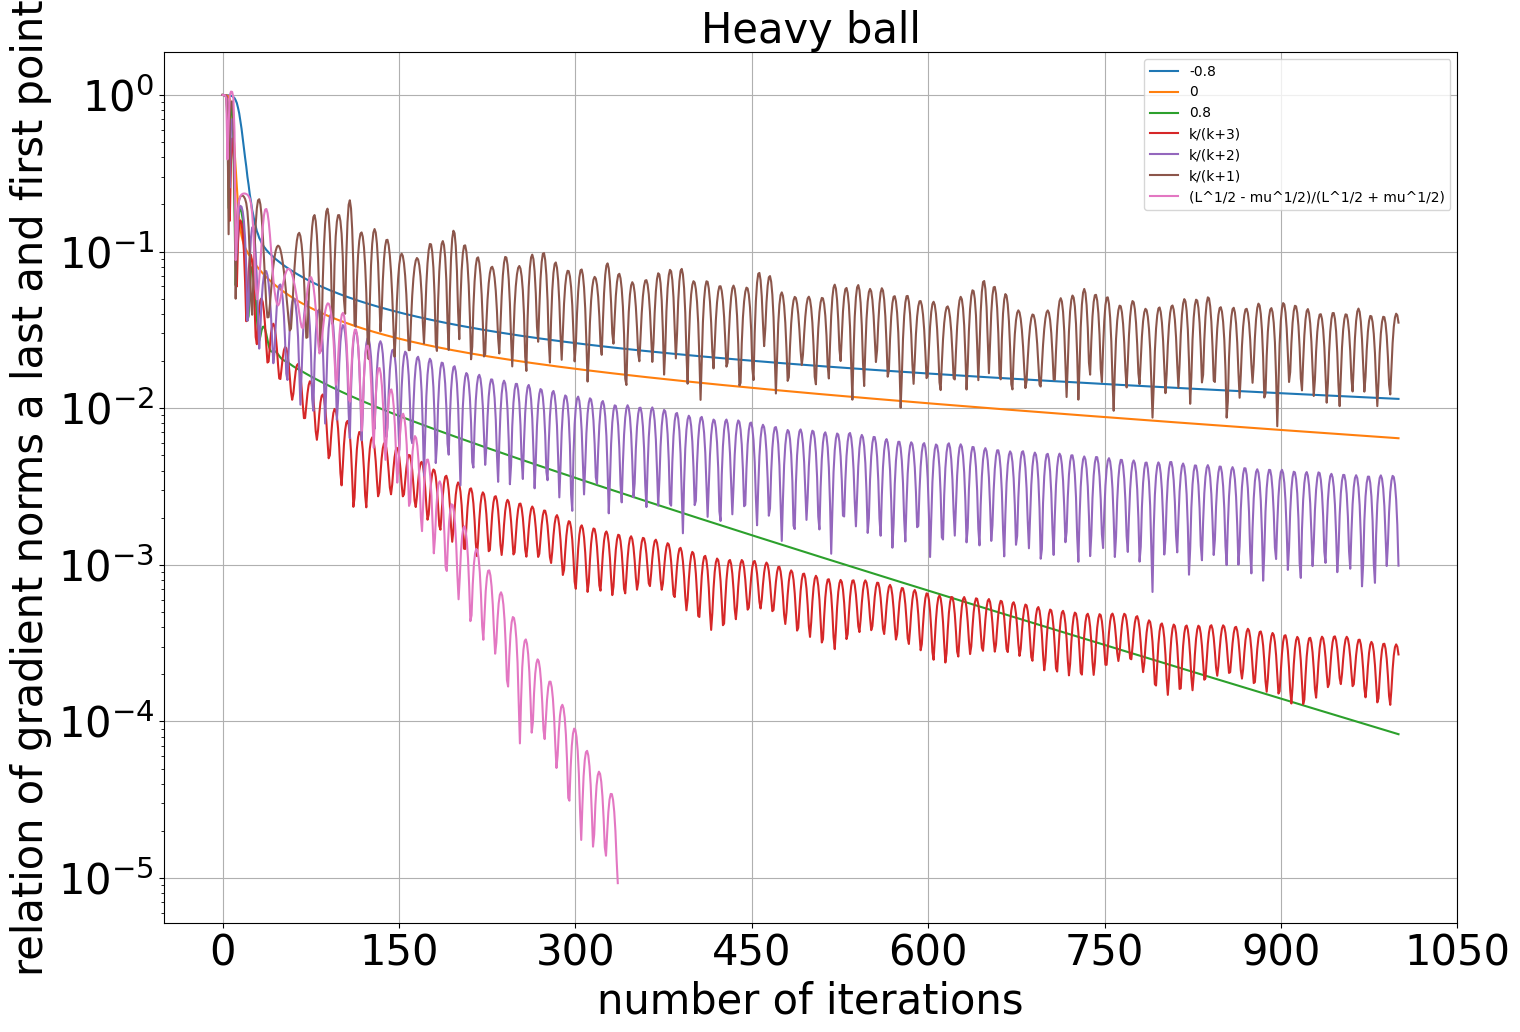

In [333]:
f,ax1 = plt.subplots(1,figsize = (15,10))

iters = 1000

tau = np.array([[-0.8] * iters, [0.] * iters, [0.8] * iters, [k / (k + 3) for k in range(1, iters + 1)], [k / (k + 2) for k in range(1, iters + 1)], [k / (k + 1) for k in range(1, iters + 1)], [(np.sqrt(L) - np.sqrt(lmbd)) / (np.sqrt(L) + np.sqrt(lmbd))] * iters])
tau_ar = ['-0.8', '0', '0.8', 'k/(k+3)', 'k/(k+2)', 'k/(k+1)', '(L^1/2 - mu^1/2)/(L^1/2 + mu^1/2)']


for i in range(len(tau)):
    omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, tau[i], lmbd, K=iters)
    plt.plot(np.linspace(0, len(criterion), len(criterion)), criterion, label=tau_ar[i])


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('relation of gradient norms a last and first point', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Heavy ball', fontsize = 30)
plt.yscale('log')
plt.show()




we see that for tau = -0.8, 0, 0.8 convergence is monotone. And best convergence shows $\tau = \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$

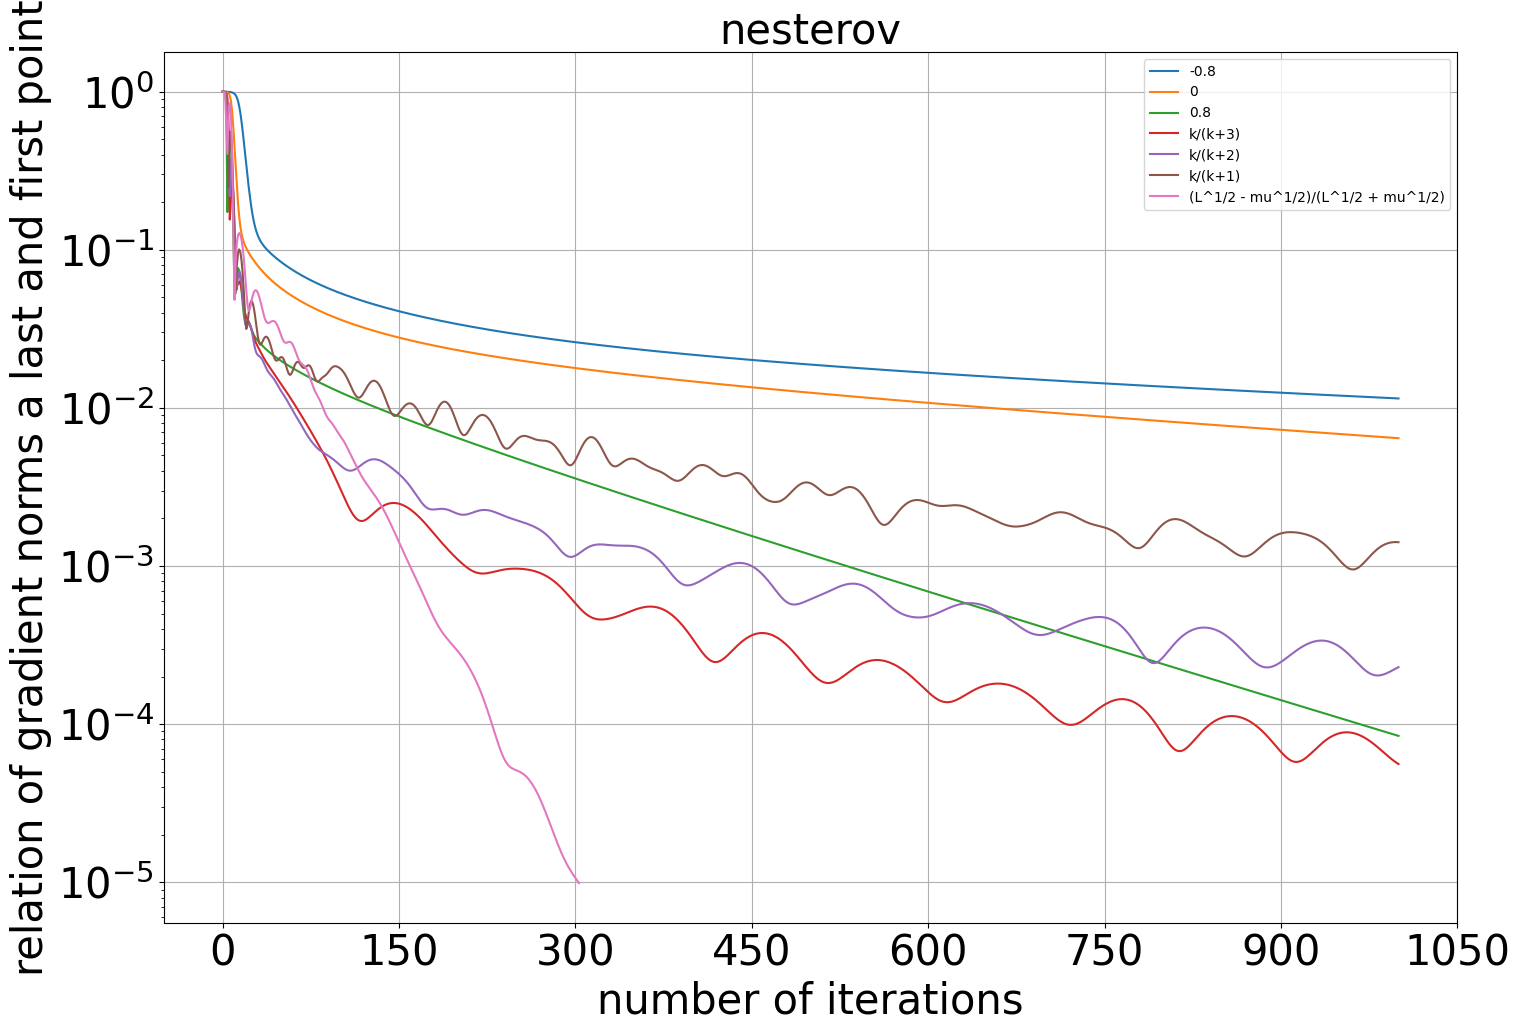

In [334]:
f,ax1 = plt.subplots(1,figsize = (15,10))

iters = 1000

tau = np.array([[-0.8] * iters, [0.] * iters, [0.8] * iters, [k / (k + 3) for k in range(1, iters + 1)], [k / (k + 2) for k in range(1, iters + 1)], [k / (k + 1) for k in range(1, iters + 1)], [(np.sqrt(L) - np.sqrt(lmbd)) / (np.sqrt(L) + np.sqrt(lmbd))] * iters])
tau_ar = ['-0.8', '0', '0.8', 'k/(k+3)', 'k/(k+2)', 'k/(k+1)', '(L^1/2 - mu^1/2)/(L^1/2 + mu^1/2)']


for i in range(len(tau)):
    omega, criterion, accuracy, T = nesterov(X_train, y_train, omega_0, gamma_k, tau[i], lmbd, K=iters)
    plt.plot(np.linspace(0, len(criterion), len(criterion)), criterion, label=tau_ar[i])


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('relation of gradient norms a last and first point', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('nesterov', fontsize = 30)
plt.yscale('log')
plt.show()


Here we see that monotonisity of convergense is much better comparing with heavy ball and again best result shows $\tau = \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$

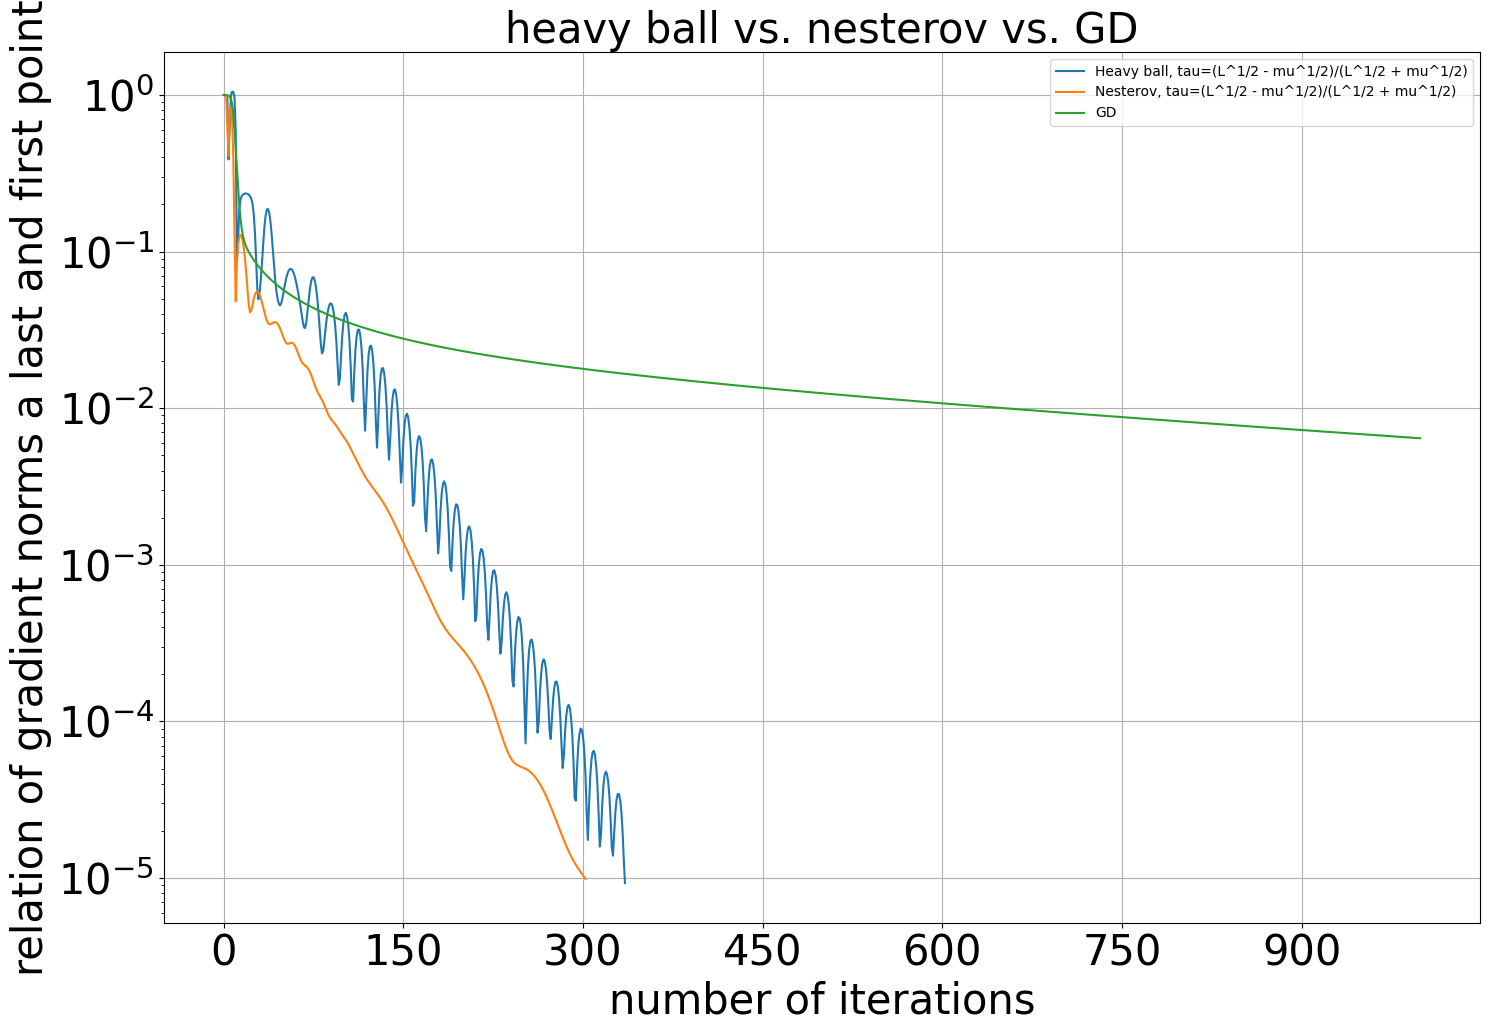

In [335]:

f,ax1 = plt.subplots(1,figsize = (15,10))

tau_gd = np.array([0] * iters)
tau_label = '(L^1/2 - mu^1/2)/(L^1/2 + mu^1/2)'

omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, np.array([tau[-1][0]] * iters), lmbd, K=iters)
plt.plot(range(len(criterion)), criterion, label='Heavy ball, tau='+tau_label)

omega, criterion, accuracy, T = nesterov(X_train, y_train, omega_0, gamma_k, np.array([tau[-1][0]] * iters), lmbd, K=iters)
plt.plot(range(len(criterion)), criterion, label='Nesterov, tau='+tau_label)


omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, tau_gd, lmbd, K=iters)
plt.plot(range(len(criterion)), criterion, label='GD')


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('relation of gradient norms a last and first point', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('heavy ball vs. nesterov vs. GD', fontsize = 30)
plt.show()




Finally we see that convergence for nesterov is much more smooth and better then for heavy ball


__c). (10 points)__ In the previous homework, we used the obtained solution of the optimization problem to predict answers on a test sample. Recall the essence: the original regression problem is a machine learning problem and using a linear model $g$ we can predict the values of labels $y$. Suppose we have a sample $x_i$, the model response for this sample is $g(w^*, x^i)$. Then the predictive rule can be formulated in the following rather natural way:
$$
y_i =
\begin{cases}
1, & g(w^*, x^i) \geq 0,
\\
-1, & g(w^*, x^i) < 0.
\end{cases}
$$
By making predictions on the test sample $X_{test}$, you can compare the result with the real labels $y_{test}$. The number of correctly guessed labels is the accuracy/accuracy of the model.

Compare on the plots the convergence of the gradient descent, heavy ball and accelerated gradient methods (with the best choice of momentum for each): 1) accuracy value from iteration number, 2) accuracy value from time. Make a conclusion.

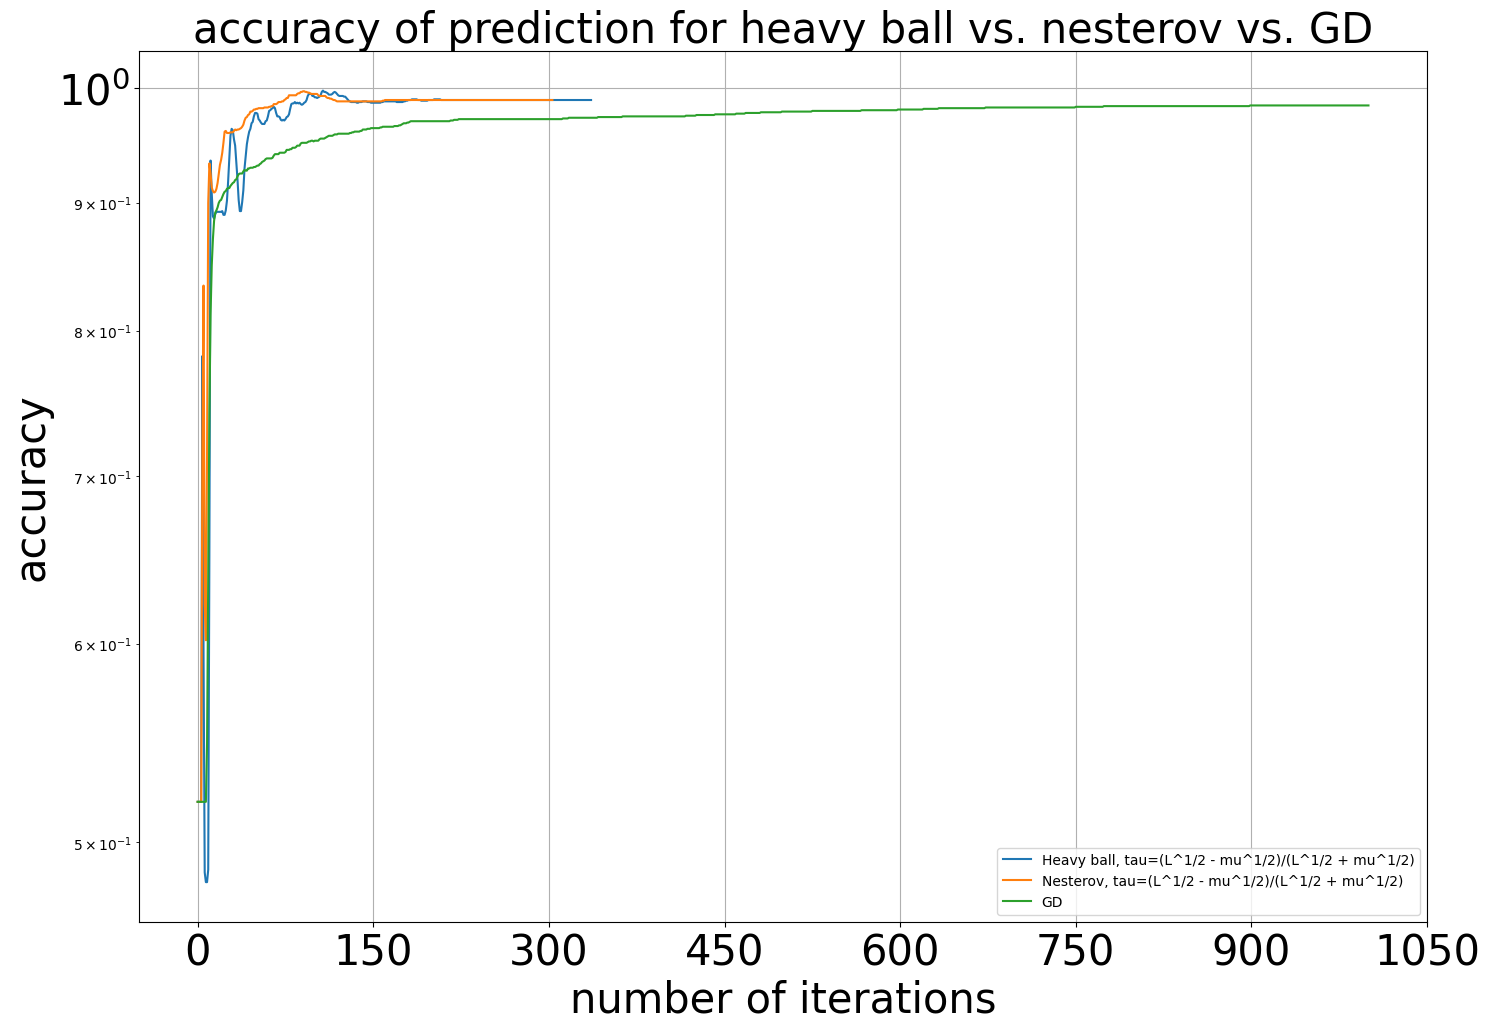

In [336]:
f,ax1 = plt.subplots(1,figsize = (15,10))

tau_gd = np.array([0] * iters)
tau_label = '(L^1/2 - mu^1/2)/(L^1/2 + mu^1/2)'

omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, np.array([tau[-1][0]] * iters), lmbd, K=iters)
plt.plot(range(len(accuracy)), accuracy, label='Heavy ball, tau='+tau_label)

omega, criterion, accuracy, T = nesterov(X_train, y_train, omega_0, gamma_k, np.array([tau[-1][0]] * iters), lmbd, K=iters)
plt.plot(range(len(accuracy)), accuracy, label='Nesterov, tau='+tau_label)


omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, tau_gd, lmbd, K=iters)
plt.plot(range(len(accuracy)), accuracy, label='GD')


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of iterations', fontsize = 30 )
ax1.set_ylabel('accuracy', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('accuracy of prediction for heavy ball vs. nesterov vs. GD', fontsize = 30)
plt.show()



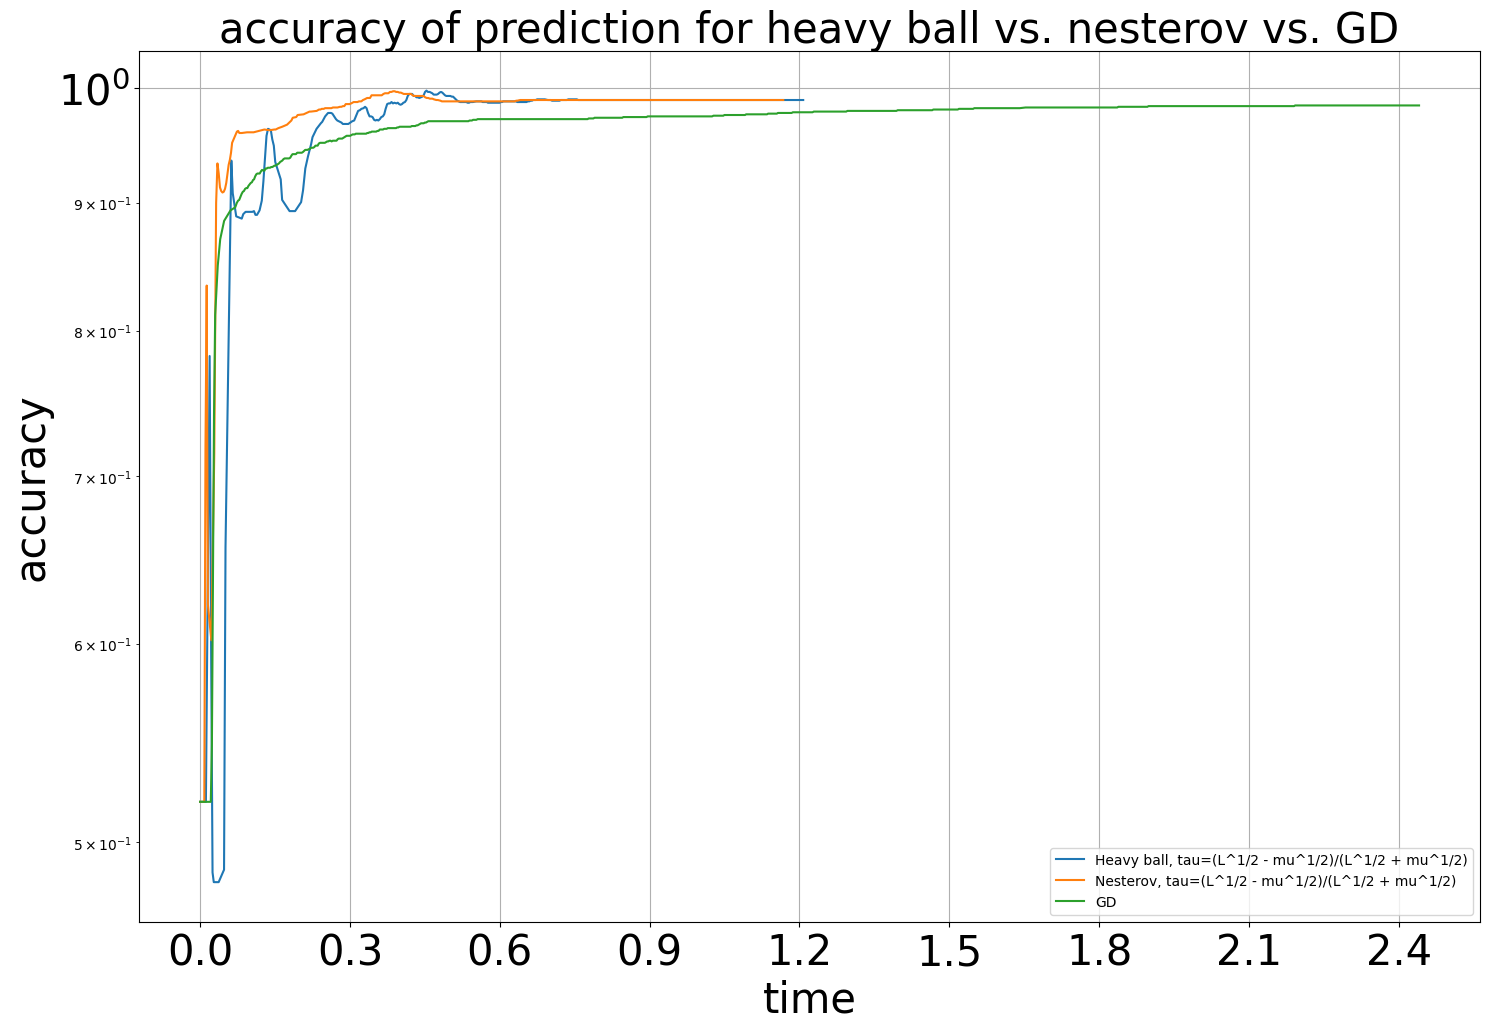

In [337]:
f,ax1 = plt.subplots(1,figsize = (15,10))

tau_gd = np.array([0] * iters)
tau_label = '(L^1/2 - mu^1/2)/(L^1/2 + mu^1/2)'

omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, np.array([tau[-1][0]] * iters), lmbd, K=iters)
plt.plot(T, accuracy, label='Heavy ball, tau='+tau_label)

omega, criterion, accuracy, T = nesterov(X_train, y_train, omega_0, gamma_k, np.array([tau[-1][0]] * iters), lmbd, K=iters)
plt.plot(T, accuracy, label='Nesterov, tau='+tau_label)


omega, criterion, accuracy, T = heavy_ball(X_train, y_train, omega_0, gamma_k, tau_gd, lmbd, K=iters)
plt.plot(T, accuracy, label='GD')


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('time', fontsize = 30 )
ax1.set_ylabel('accuracy', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('accuracy of prediction for heavy ball vs. nesterov vs. GD', fontsize = 30)
plt.show()

From both plots we see that convergence speed is better for nesterov method, but appoximately in 150 iterations score for nesterov and heavy ball become equall.
Same time score for GD is always lower

### Part 2. Solving the constrained optimization problem

Still consider the empirical risk minimization problem:
\begin{equation}
\min_{w \in \mathcal{X} \subset \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i),
\end{equation}
where $\ell$ is the loss function, $g$ is the model, $w$ is the model parameters, $\{x_i, y_i\}_{i=1}^n$ is the data sample from feature vectors $x_i$ and labels $y_i$.

And as in the previous part, we use the linear model $g(w, x) = w^T x$ and the logistic/sigmoidal loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__).

As the set $\mathcal{X}$, let us take a $\ell_1$-ball with center at 0 and radius $R$ (a parameter that can be changed): $\mathcal{X} =\{x  \mid x \in \mathbb{R}^d \mid \| x \|_1 \leq R \}$.

__Differences from the previous part:__ removed the regularizer, added the set $\mathcal{X}$.

We continue to work with _mushrooms_ dataset.

__Problem. (30 + 30 points)__ Since we are now solving an optimization problem on a ball, methods that take this into account are needed.

__a). (5 points)__ For a $\ell_1$-ball with center at 0 and radius $R$, find an expression for solving a linear optimization problem given a vector $g \in \mathbb{R}^d$:
$$
s^* = \arg \min_{s \in \mathcal{X}} \langle s, g \rangle.
$$
Formally justify your answer.

$$
\langle s, g \rangle = \sum\limits_{i=1}^d sign(s_i) sign(g_i)  |s_i| |g_i|
$$

If $sign(s_i)=-sign(g_i)$ then

$$
\sum\limits_{i=1}^d sign(s_i) sign(g_i)  |s_i| |g_i| \geq -\sum\limits_{i=1}^d|s_i| |g_i| \geq -\sum\limits_{i=1}^d |s_i| \max\limits_{i} |g_i| \geq -R \max\limits_{i} |g_i|
$$
because $\|s\|_1=\sum\limits_{i=1}^d|s_i| \leq R$

So we have found lower bound which achieves if  $ s=-Re_isign(g_i)$, where $e_i=(0, ..., 1, ..., 0)^T $, and $i: i = \text{arg}\max_j|g_j|$.




__b). (5 points)__ Implement separately the solution of the linear optimization problem from the previous point (it is better to pass the radius of the ball $R$ as a parameter). Implement the Frank-Wolfe method for our problem. For the tasks below, you may need to be able to measure the running time of the method. We also advise to take a step in the algorithm as follows: if iterations are numbered from 0, then $\gamma = \frac{2}{k+3}$, if iterations are numbered from 1, then $\gamma = \frac{2}{k+2}$.

In [338]:
def FW(X, y, omega_0, gammas, lmbd, R, K = 10**3, eps = 10**(-5)):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    grad_0 = grad_f(omega_0, X, y, lmbd)

    omega = omega_0
    criterion = True
    i = 0

    while  i < K and criterion:
        start = time.time()


        grad = grad_f(omega, X, y, lmbd)
        omega_new = (1 - gammas[i]) * omega + gammas[i] * gap(grad, R)

        grad_new = grad_f(omega_new, X, y, lmbd)
        Y = gap(grad_new, R)
        tmp = np.dot(grad_new, omega_new - Y)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1
        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T

In [339]:
def gap(g, R):

    idx = np.argmax(np.abs(g))
    s = np.zeros(g.shape)

    if g[idx] >= 0:
        s[idx] = -1

    else:
        s[idx] = 1

    return R * s

__с). (10 points)__ Solve the optimization problem on the training sample using the implemented methods. Take $R = 5$ and a stratum point at $0$. Use the following expression as the criterion:
$$
\text{gap}(w^k) = \max_{y \in \mathcal{X}} \langle \nabla f(w^k), w^k - y \rangle,
$$
or the average version of $\frac{1}{k} \sum_{i=1}^k \text{gap}(w^i)$. We use such a criterion because we do not know the value of $f^*$ and cannot guarantee that $\nabla f(w^*) = 0$. But we can show that $\text{gap}(w^k) \geq f(w^k) - f^*$ and also prove the convergence of the Frank-Wolfe method by such a criterion, and hence convergence by $\text{gap}(w^k)$ and gives a good understanding about the behavior of $f(w^k) - f^*$.

Draw the convergence plot: the value of the convergence criterion from the iteration number.

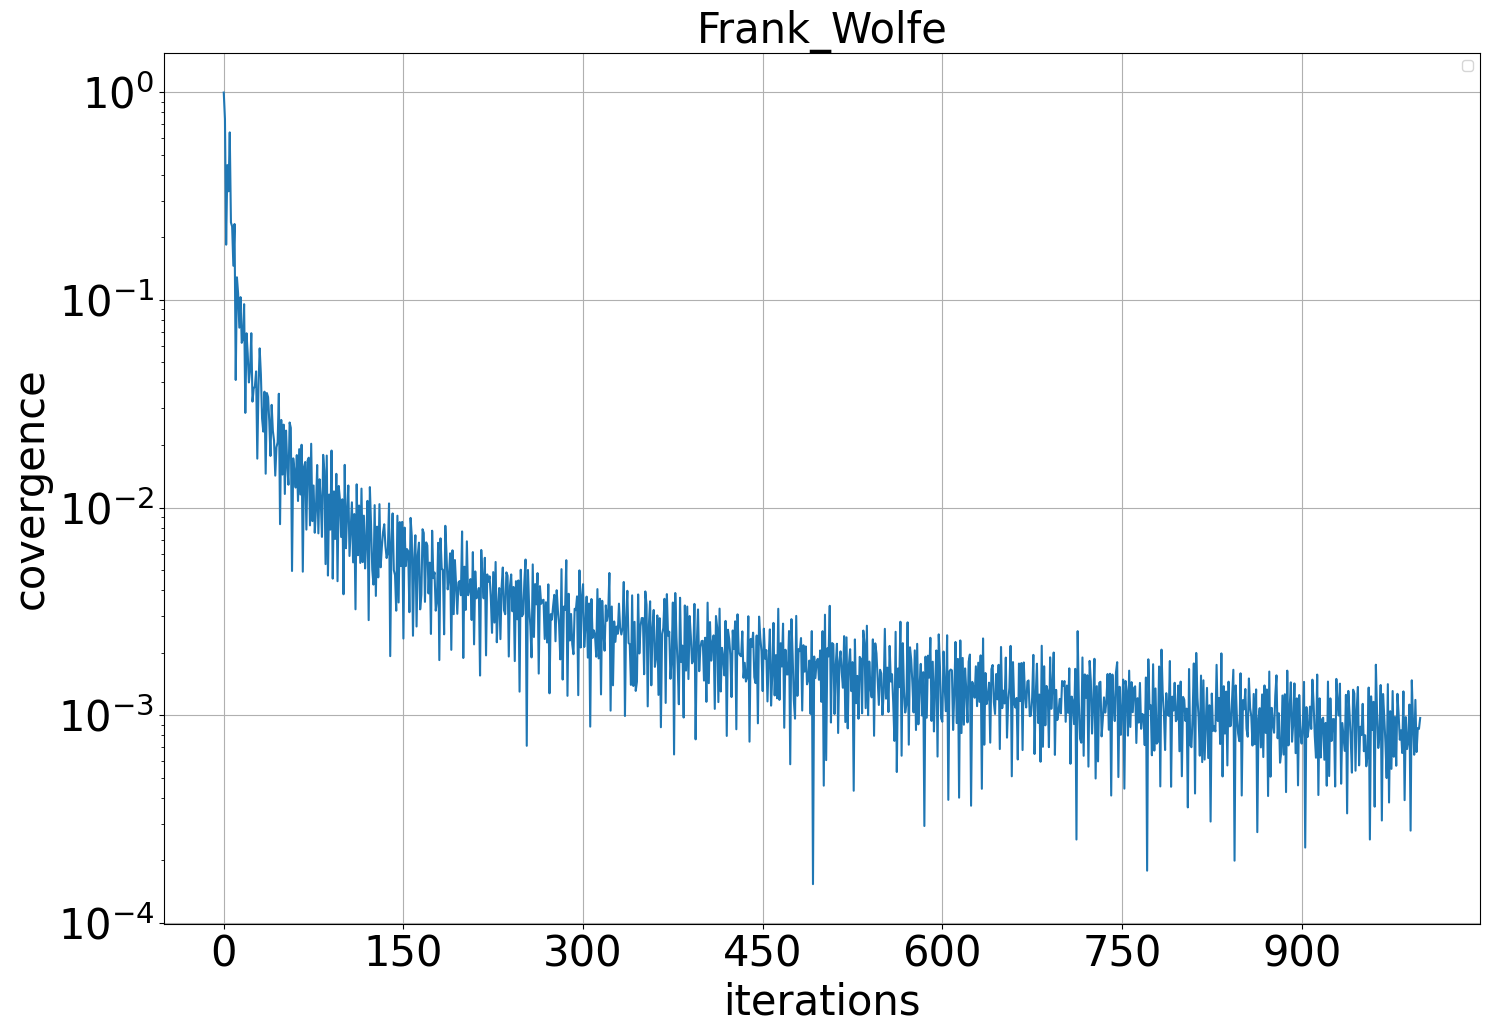

In [340]:
f,ax1 = plt.subplots(1,figsize = (15,10))

iters = 1000

omega_0 = np.zeros((X_train.shape[1],))
gammas = np.array([2 / (k + 2) for k in range(1, iters + 1)])
R = 5
lmbd = 0


omega, criterion, accuracy, times = FW(X_train, y_train, omega_0, gammas, lmbd, R)

plt.plot(range(len(criterion)), criterion)

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('covergence', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Frank_Wolfe', fontsize = 30)
plt.show()


Show the solution obtained using the Frank-Wolfe method. What unusual things do you see? For more clarity, you can use Nesterov's method from the previous task and solve the unconditional problem (on $\mathbb{R}^d$) without the regularizer. Make a conclusion.

Convergence criteria is highly oscillating

In [341]:
omega

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.04575664e-01,  0.00000000e+00,  0.00000000e+00,
       -9.97246267e-01,  0.00000000e+00,  0.00000000e+00,  2.09174059e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -6.97904890e-05,  0.00000000e+00,  1.38583971e-03,
       -7.47805089e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.98204191e-05, -

We see that solution is highly sparse. Let's look at the solution obtained with nesterov method

In [342]:
iters = 1000

L = lipschitz_constan(X_train)
lmbd = 0
gamma_k = 1 / L

tau = np.array([1] * iters)


omega, criterion, accuracy, T = nesterov(X_train, y_train, omega_0, gamma_k, tau, lmbd, K=iters)
omega


array([ -11.43806377,   -6.32201645,    0.59979978,   -3.05355274,
          9.6519561 ,    2.75511716,   -9.37667377,    2.27632073,
        -14.06254805,   13.35614116,   21.96134218,  -31.82011345,
         -5.1858181 ,   -5.93145154,   26.01065054,  -32.47154648,
         14.49759328,   16.72884208,  -13.38363851,    1.78738008,
        -10.97772766,    3.17096774,   48.18317437,  -71.63877722,
       -100.21727236,   -2.66516986,   47.52386958,  146.73417989,
        -38.42768634,  -18.98599722,  -18.31308077,   10.82541309,
        -18.63217301,  -31.49628336,   23.68952343,   71.25269407,
        -79.05945399,  -54.99061453,    5.72942519,    7.09284217,
         -1.77396874,   14.91546822,    4.11565536,   16.43292106,
         14.01200327,  -21.16886883,    6.70275309,    7.48289222,
         -6.3572684 ,  -32.88927752,   25.0825176 ,  -14.73661479,
         25.02517378,  -43.12184336,   25.02652445,   -9.48781113,
        -14.38420961,  -36.60745355,   52.67271436,   -2.66516

Here we see opposit effect, solution is dence.

I guess this difference comes from the fact that using Frack-Wolfe algorithm we contiuosly serched parameters from L1 ball

__d). (10 points)__ In the previous part, we used the obtained solution of the optimization problem to predict answers on a test sample. See what the model trained with the Frank-Wolfe method gives. Vary $R = 5, 10, 20, 50, 100, 1000$. Draw three plots: 1) the accuracy of the final model from $R$, 2) the number of non-zero components in the final solution of the Frank-Wolfe method from $R$, 3) the accuracy from the number of non-zero components in the final solution. Make a conclusion

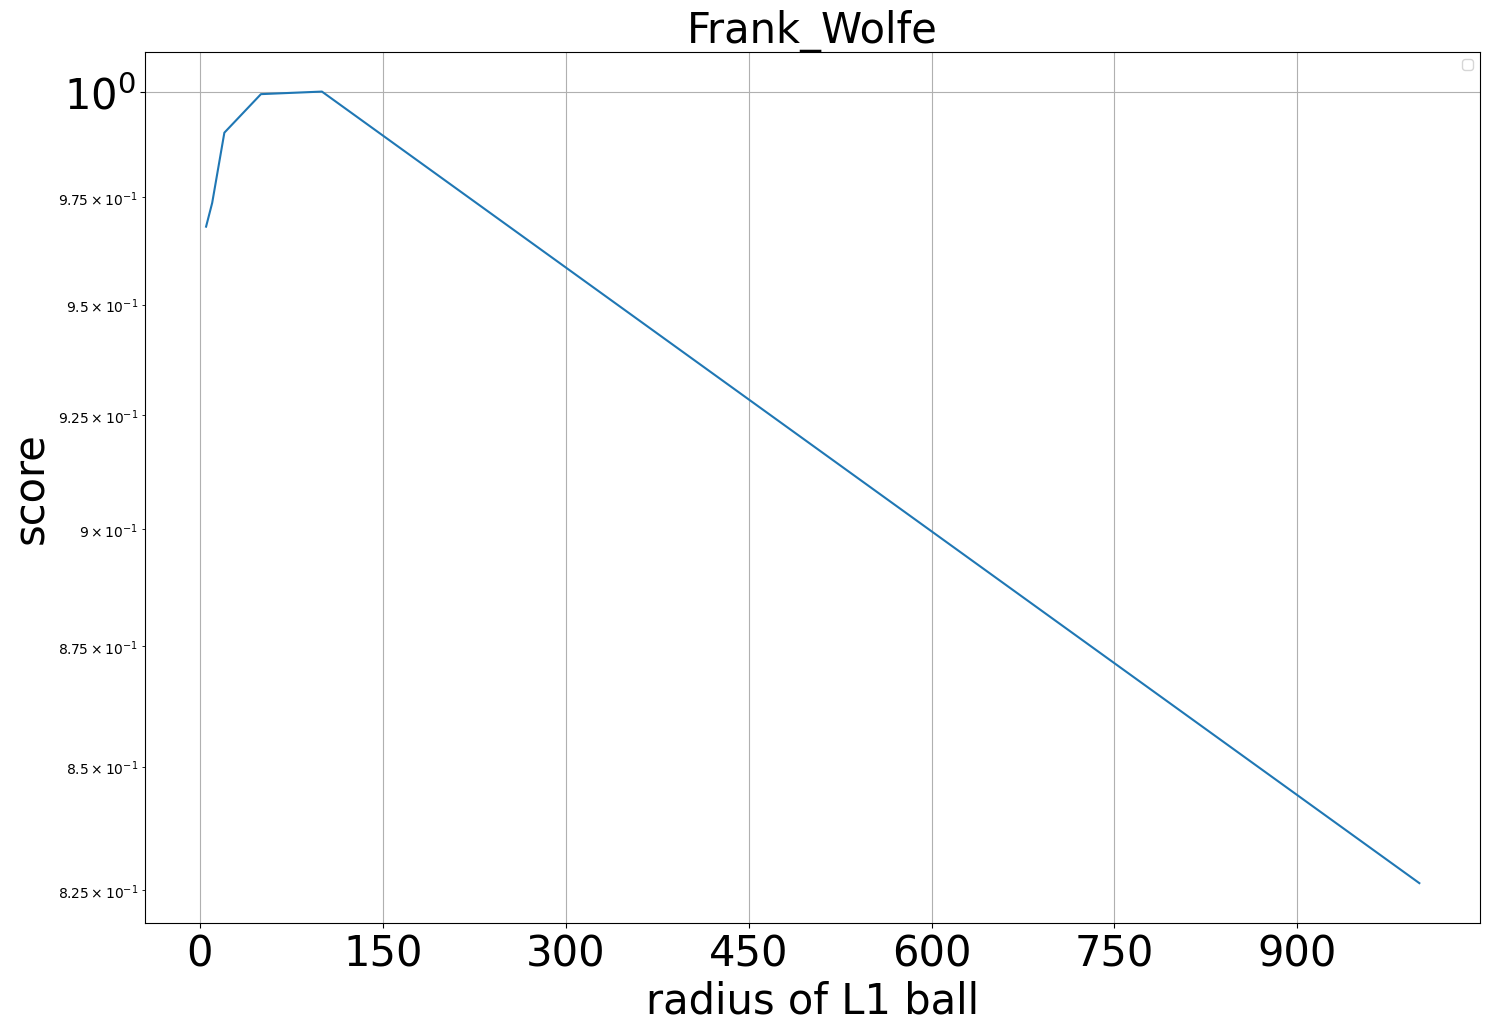

In [343]:
f,ax1 = plt.subplots(1,figsize = (15,10))

lmbd = 0
omega_0 = np.zeros((X_train.shape[1],))
R = np.array([5, 10, 20, 50, 100, 1000])

accuracy_array = np.array([])

for i in range(len(R)):
    omega, criterion, accuracy, times = FW(X_train, y_train, omega_0, gammas, lmbd, R[i])

    accuracy_array = np.append(accuracy_array, accuracy[-1])

plt.plot(R, accuracy_array)

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('radius of L1 ball', fontsize = 30 )
ax1.set_ylabel('score', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Frank_Wolfe', fontsize = 30)
plt.show()

From the plot we see that it is possible to tune radius R such that constraned optimization solves problem even without any reqularization

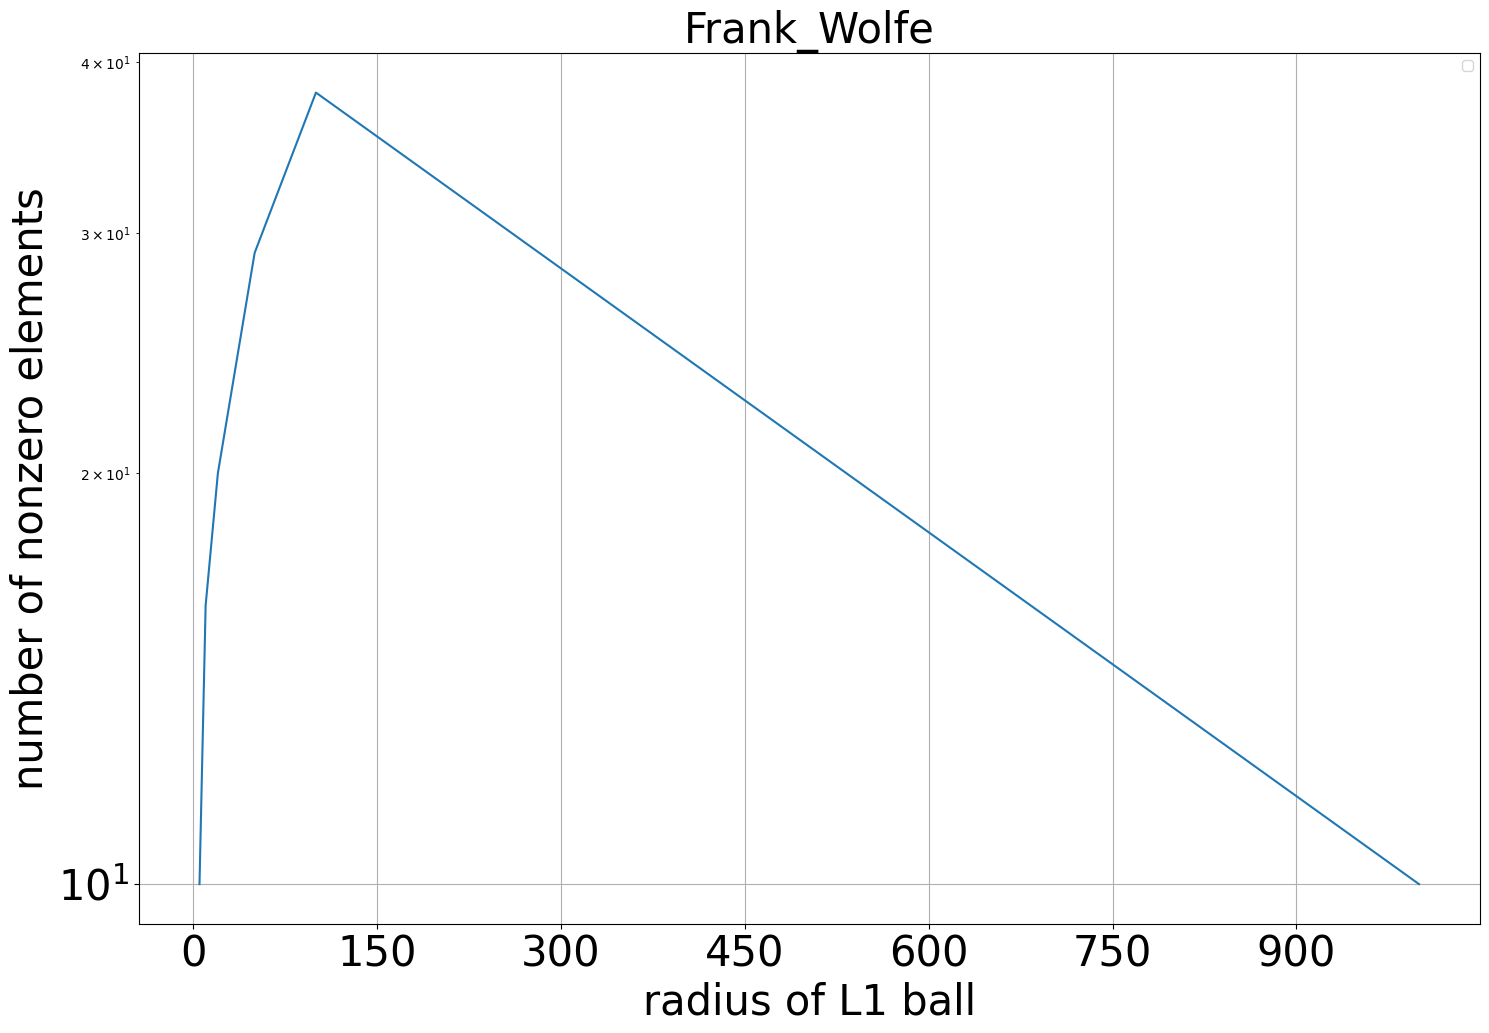

In [344]:
f,ax1 = plt.subplots(1,figsize = (15,10))

lmbd = 0
omega_0 = np.zeros((X_train.shape[1],))
R = np.array([5, 10, 20, 50, 100, 1000])

nonzero_array = np.array([])

for i in range(len(R)):
    omega, criterion, accuracy, times = FW(X_train, y_train, omega_0, gammas, lmbd, R[i])

    nonzero_array = np.append(nonzero_array, (omega != 0).sum())

plt.plot(R, nonzero_array)

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('radius of L1 ball', fontsize = 30 )
ax1.set_ylabel('number of nonzero elements', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Frank_Wolfe', fontsize = 30)
plt.show()

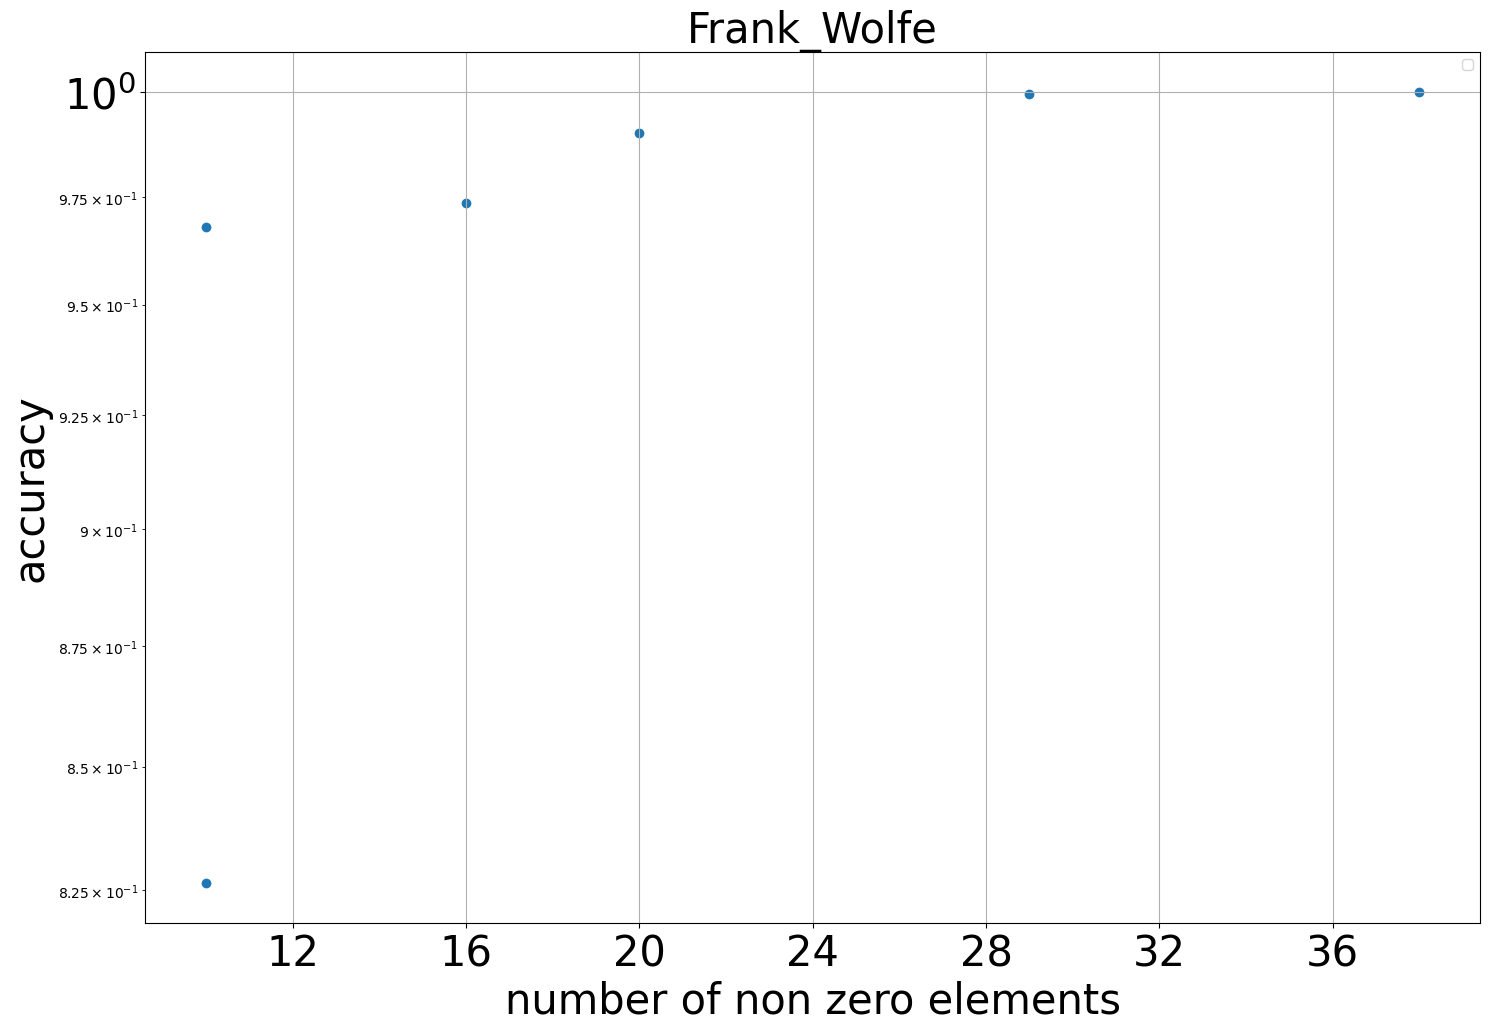

In [345]:
f,ax1 = plt.subplots(1,figsize = (15,10))

lmbd = 0
omega_0 = np.zeros((X_train.shape[1],))
gammas_k = np.array([2 / (k + 2) for k in range(1, iters + 1)])
R = np.array([5, 10, 20, 50, 100, 1000])

nonzero_array = np.array([])
accuracy_array = np.array([])

for i in range(len(R)):
    omega, criterion, accuracy, times = FW(X_train, y_train, omega_0, gammas, lmbd, R[i])

    accuracy_array = np.append(accuracy_array, accuracy[-1])
    nonzero_array = np.append(nonzero_array, (omega != 0).sum())

plt.scatter(nonzero_array, accuracy_array)

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('number of non zero elements', fontsize = 30 )
ax1.set_ylabel('accuracy', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('Frank_Wolfe', fontsize = 30)
plt.show()

__e). (bonus 30 points)__ Our problem can also be solved using the gradient descent method with Euclidean projection. To do this, you need to know how to make a projection onto a $\ell_1$-ball. Find a way to make the projection in the Internet, just google: "projection onto l1 ball." State here the essence of the found approach (attach a link where you get the approach from) and implement it in the code.

In [346]:
#your solution (Code and Markdown)

Solve the optimization problem on a training sample using gradient descent with Euclidean projection. Compare on the plots the convergence of gradient descent and Frank-Wolfe method: 1) criterion value from iteration number, 2) criterion value from time. Make a conclusion.

In [347]:
#your solution (Code and Markdown)

### Part 3. Solving the stochastic optimization problem

Let us comeback to the empirical risk minimization with reguralizer:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

We continue to work with _mushrooms_ dataset.

__Problem (40 + 30 points).__ This part of the assignment is related to stochastic methods.

__a). (5 points)__  Implement the ability to uniformly divide the training part of the dataset into batches of size $b$ ($b$ is a parameter).

In [348]:
def split(X, y, size):

    X_ind = range(X.shape[0])
    batches_ind = []
    X_batches = []
    y_batches = []

    i = 0
    while i + size <= len(X_ind):

        batches_ind.append(X_ind[i:i + size])
        X_batches.append(X[X_ind[i:i + size]])
        y_batches.append(y[X_ind[i:i + size]])
        i += size

    return X_batches, y_batches, batches_ind

__b). (5 points)__ Implement the SGD method:
$$
w^{k+1} = w^k - \gamma_k \nabla f_{j_k} (w^k),
$$

where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$. For the tasks below, you may need to be able to measure the running time of the method.

In [349]:

def stochastic_gd(X, y, omega_0, gamma_k, lmbd, batch_size, K = 10**3, eps = 1e-5):

    criterions = np.array([])
    T = np.array([0])
    accuracy = np.array([(y_test == np.where(X_test @ omega_0 >= 0, 1, -1)).mean()])

    X_batch, y_batch, batch_ind = split(X, y, batch_size)
    grad_0 = grad_f(omega_0, X, y, lmbd)
    omega = omega_0
    criterion = True
    i = 0
    while  i < K and criterion:

        start = time.time()

        j = np.random.randint(0, len(X_batch))

        grad = grad_f(omega, X_batch[j], y_batch[j], lmbd)

        omega_new = omega - gamma_k[i] * grad

        tmp = np.linalg.norm(grad) / np.linalg.norm(grad_0)

        if tmp < eps:
            criterion = False

        criterions = np.append(criterions, tmp)

        end = time.time() - start

        if len(T) > 0:
            end += T[-1]

        i += 1
        omega = omega_new

        accuracy = np.append(accuracy, (y_test == np.where(X_test @ omega >= 0, 1, -1)).mean())
        T = np.append(T, end)

    return omega, criterions, accuracy, T


__c). (5 points)__ Solve the optimization problem on the training sample using the implemented method. Take $b = 10$, and the step is $\gamma_k \equiv \frac{1}{L}$. Draw the convergence plot: the value of the convergence criterion (e.g. $\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number. Make a conclusion.

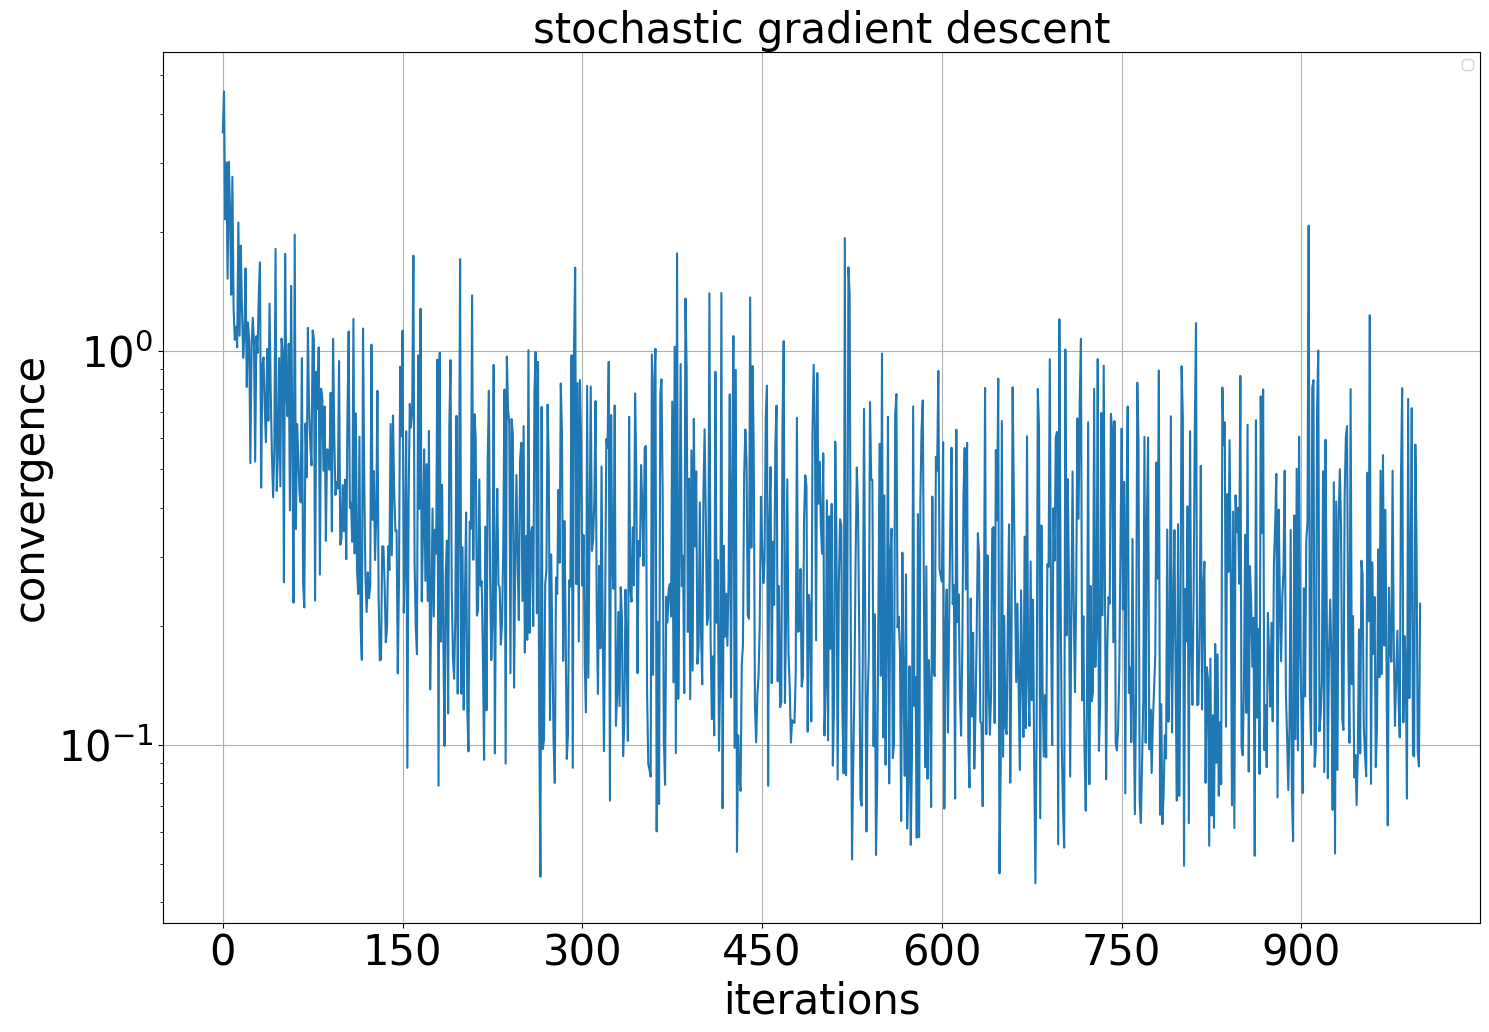

In [350]:

f,ax1 = plt.subplots(1,figsize = (15,10))

L = lipschitz_constan(X_train)
lmbd = L / 1000.

iters = 1000

omega_0 = np.zeros((X_train.shape[1],))
gamma = np.array([1 / L] * iters)
batch_size = 10


omega, criterion, accuracy, times = stochastic_gd(X, y, omega_0, gamma, lmbd, batch_size)

plt.plot(range(len(criterion)), criterion)

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('convergence', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('stochastic gradient descent', fontsize = 30)
plt.show()


Method is unstable and noisy, by we expect such behaviour

__d). (10 points)__ Vary the batch size: $b = 1, 10, 100, 1000$, and take the step size equal to $\gamma_k \equiv \frac{1}{L}$. Draw the convergence plot: the value of the convergence criterion from the iteration number for each $b$. Does this plot reflect a fair comparison? Why? Figure out how to compare the results to each other more honestly and draw a new comparison plot. Make a conclusion.

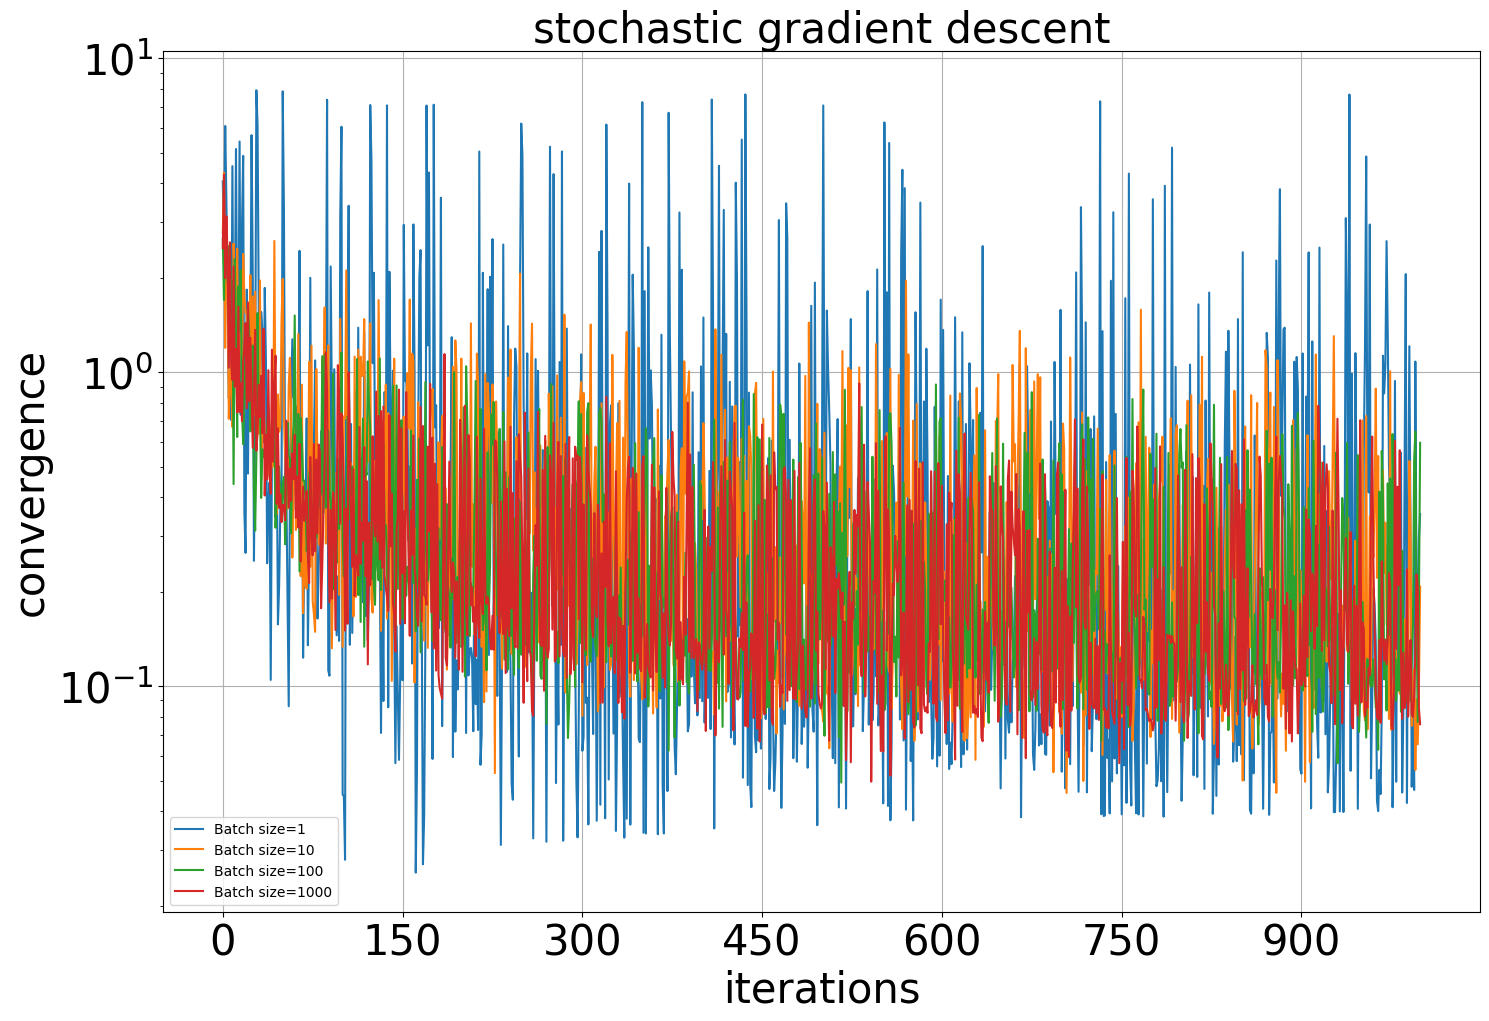

In [351]:
f,ax1 = plt.subplots(1,figsize = (15,10))

batch_sizes = [1, 10, 100, 1000]
iters = 1000


for i in range(len(batch_sizes)):

    omega, criterion, accuracy, times = stochastic_gd(X, y, omega_0, gamma, lmbd, batch_sizes[i])

    plt.plot(range(len(criterion)), criterion, label='Batch size='+str(batch_sizes[i]))

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('convergence', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 10)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('stochastic gradient descent', fontsize = 30)
plt.show()

Variance is too big and we can hardly conclude based on above plot. That's why let's look on plot for average values

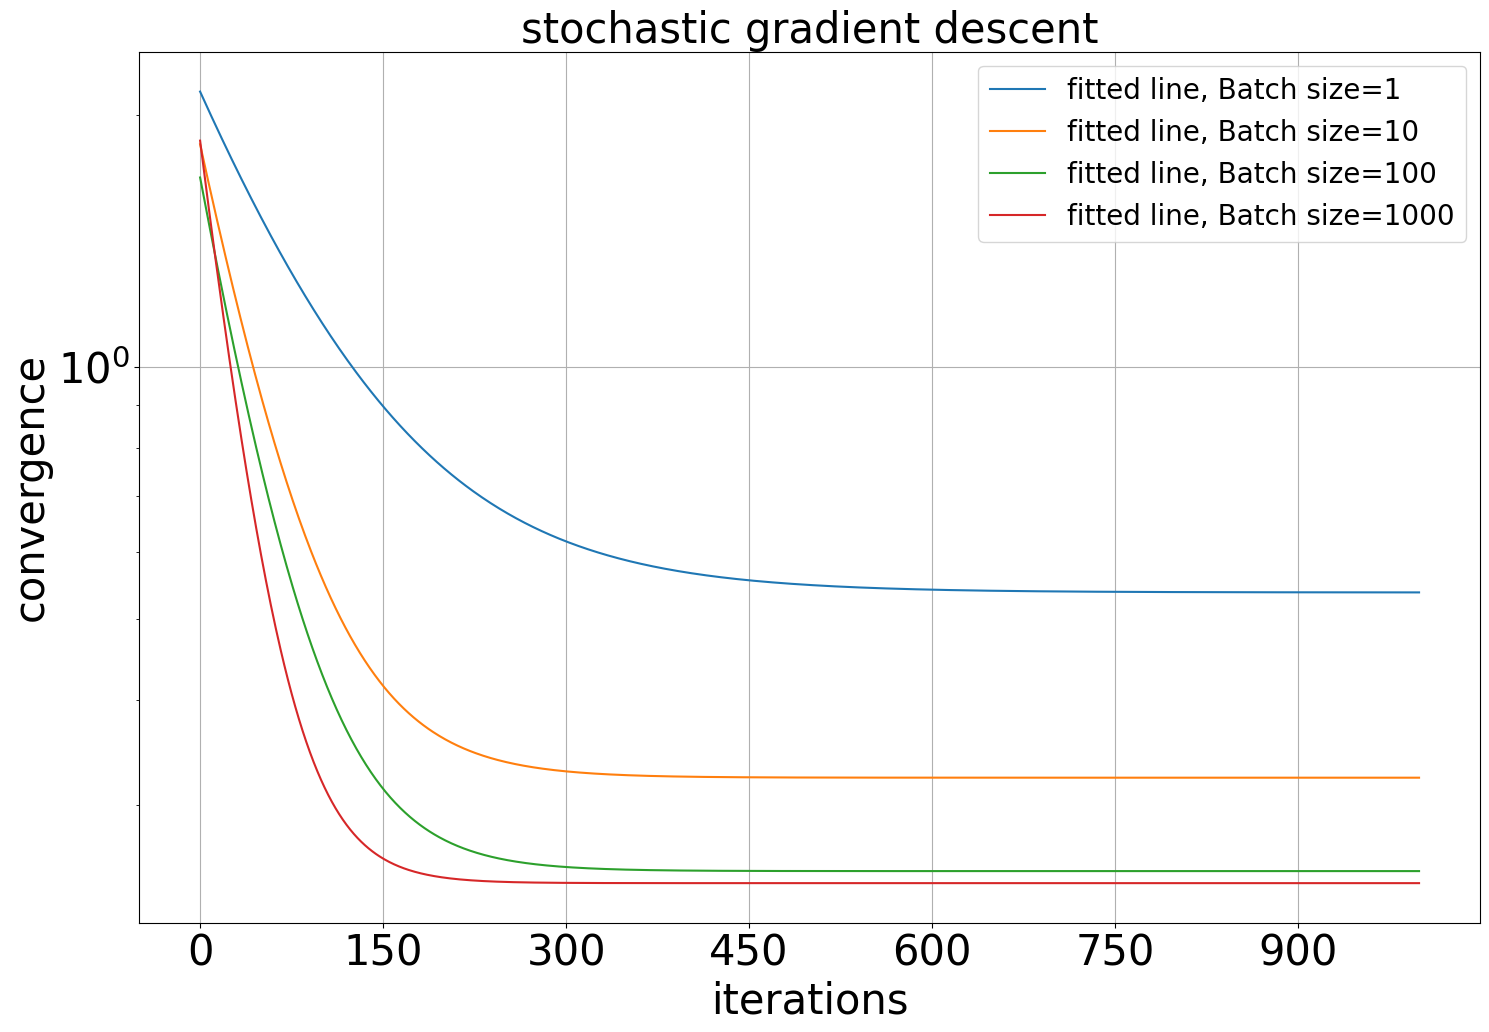

In [352]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c



f,ax1 = plt.subplots(1,figsize = (15,10))

batch_sizes = [1, 10, 100, 1000]
iters = 1000


for i in range(len(batch_sizes)):

    omega, criterion, accuracy, times = stochastic_gd(X, y, omega_0, gamma, lmbd, batch_sizes[i])

    popt, pcov = curve_fit(func, range(len(criterion)), criterion)


    plt.plot(range(len(criterion)), func( range(len(criterion)), *popt),
            label='fitted line, Batch size='+str(batch_sizes[i]))

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('convergence', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 20)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('stochastic gradient descent', fontsize = 30)
plt.show()

Now we can conclude, the more batch size, the better convergence

__e). (10 points)__ Let us fix $b = 10$ and try to change the strategy of choosing the step:

1) $\gamma_k \equiv \frac{1}{L}$ as we did before,

2) $\gamma_k \equiv \text{const}$, selecting $\text{const}$ to get the "best" convergence (explain what you mean by "best"),

3) $\gamma_k = \frac{1}{\sqrt{k + 1}}$,

4) $\gamma_k = \frac{1}{k + 1}$.

Draw the convergence plot: the value of the convergence criterion from the iteration number. Make a conclusion.

Based on previous hw $const = 1.5 / L$

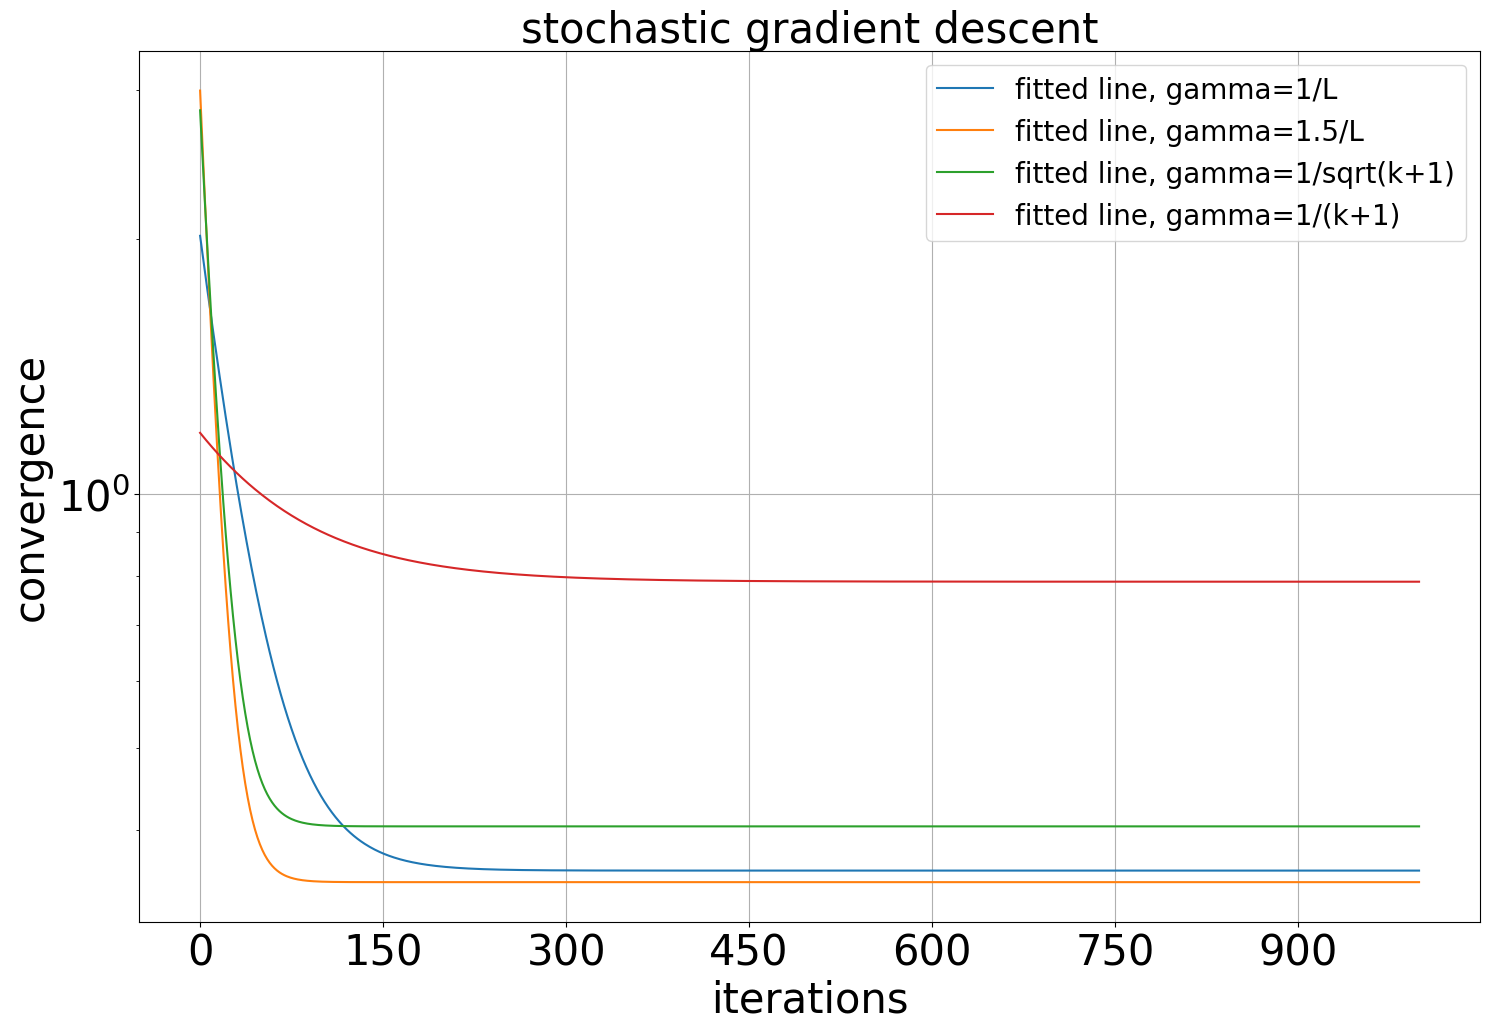

In [353]:


f,ax1 = plt.subplots(1,figsize = (15,10))

batch_size = 10
iters = 1000
gamma = np.array([[1 / L] * iters, [1.5 / L] * iters, [1. / np.sqrt(k + 1) for k in range(iters)], [1. / (k + 1) for k in range(iters)]])
gamma_array = ['1/L', '1.5/L', '1/sqrt(k+1)', '1/(k+1)']


for i in range(len(gamma)):

    omega, criterion, accuracy, times = stochastic_gd(X, y, omega_0, gamma[i], lmbd, batch_size)

    popt, pcov = curve_fit(func, range(len(criterion)), criterion)


    plt.plot(range(len(criterion)), func( range(len(criterion)), *popt),
            label='fitted line, gamma='+str(gamma_array[i]))

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('convergence', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 20)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('stochastic gradient descent', fontsize = 30)
plt.show()

We can conclude that best convergence gives gamma = 1.5 / L

__f). (5 points)__ Look at the accuracy of the model trained with SGD. Repeat point d)-e), but now plot the accuracy dependence, not the convergence criterion. Make a conclusion.

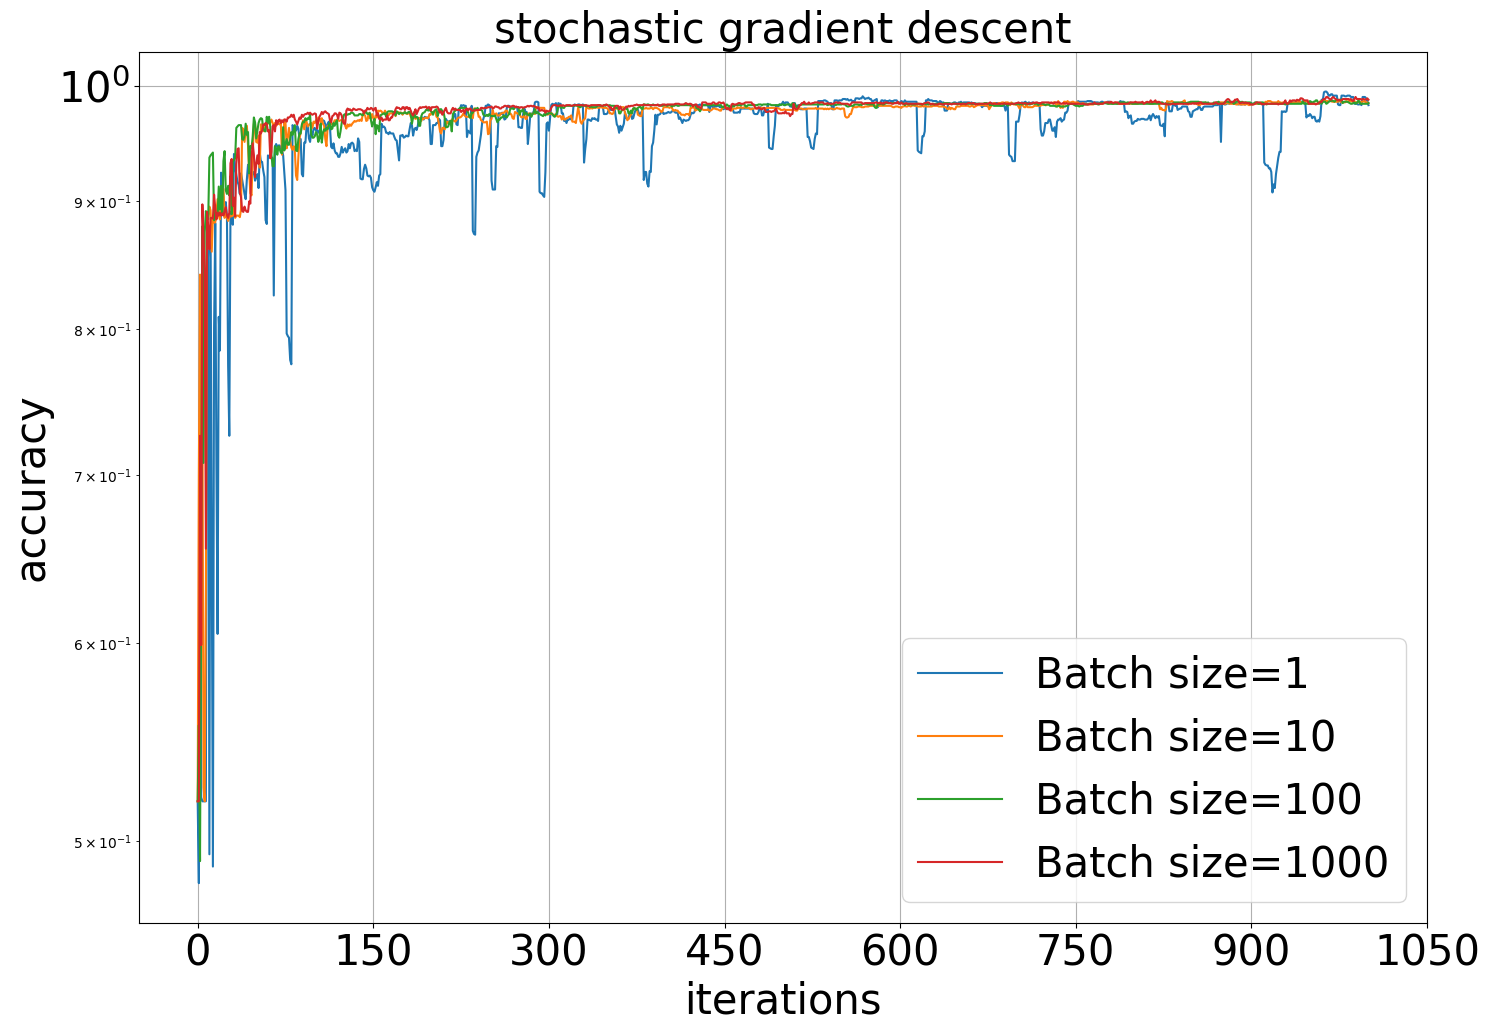

In [354]:
f,ax1 = plt.subplots(1,figsize = (15,10))

batch_sizes = [1, 10, 100, 1000]
iters = 1000
gamma = np.array([1 / L] * iters)


for i in range(len(batch_sizes)):

    omega, criterion, accuracy, times = stochastic_gd(X, y, omega_0, gamma, lmbd, batch_sizes[i])

    plt.plot(range(len(accuracy)), accuracy, label='Batch size='+str(batch_sizes[i]))

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('accuracy', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 30)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('stochastic gradient descent', fontsize = 30)
plt.show()

the more batch size, the better and the more stable accuracy

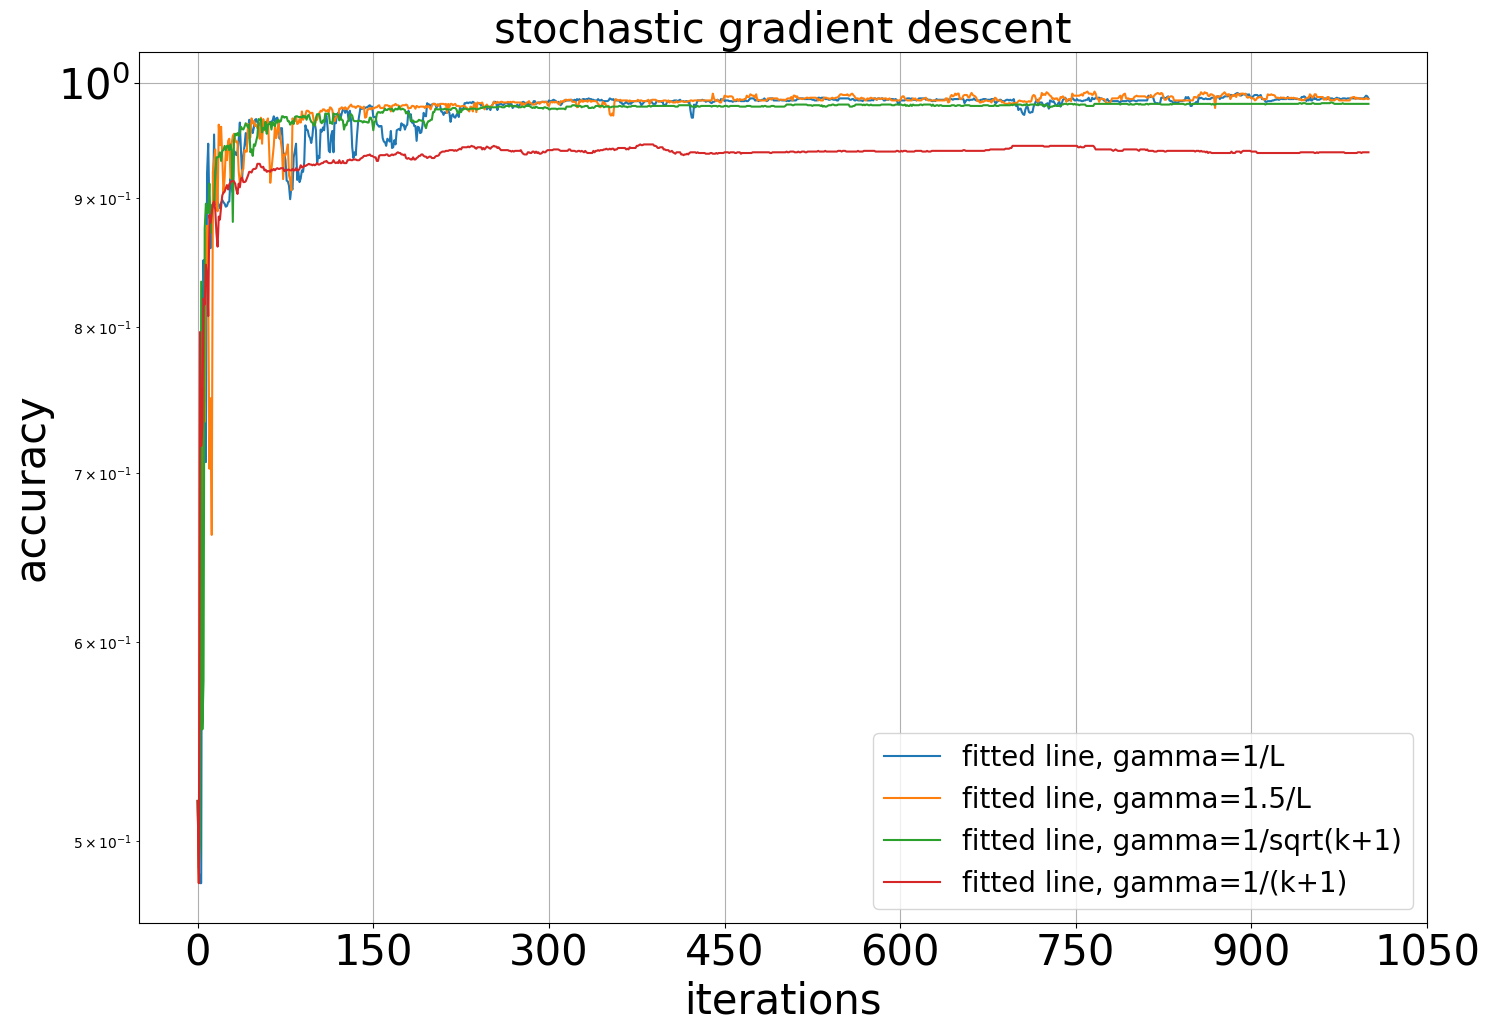

In [355]:

f,ax1 = plt.subplots(1,figsize = (15,10))

batch_size = 10
iters = 1000
gamma = np.array([[1 / L] * iters, [1.5 / L] * iters, [1. / np.sqrt(k + 1) for k in range(iters)], [1. / (k + 1) for k in range(iters)]])
gamma_array = ['1/L', '1.5/L', '1/sqrt(k+1)', '1/(k+1)']


for i in range(len(gamma)):

    omega, criterion, accuracy, times = stochastic_gd(X, y, omega_0, gamma[i], lmbd, batch_size)


    plt.plot(range(len(accuracy)), accuracy,
            label='fitted line, gamma='+str(gamma_array[i]))

ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('iterations', fontsize = 30 )
ax1.set_ylabel('accuracy', fontsize = 30 )

#ax1.set_ylabel('$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$', fontsize = 30 )

ax1.legend(fontsize = 20)
plt.yscale('log')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('stochastic gradient descent', fontsize = 30)
plt.show()


gamma = 1.5 / L gives best accuracy

__g). (bonus 3 $\times$ 10 points)__ Implement the SAGA (Section A.5 of [paper](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (Section А.9 from [paper](https://arxiv.org/pdf/1905.11261.pdf)) and SARAH ([paper](https://arxiv.org/pdf/1703.00102.pdf)) methods for our problem. Solve the optimization problem on the training sample using the new implemented methods. Take $b = 10$, and hyperparameters of methods according to the theory (see corresponding papers). Write these parameters. Is the iteration number a fair for comparison of these methods? Figure out how to compare the results more honestly. Draw the comparison plots of SGD (with step $\gamma_k \equiv \frac{1}{L}$), SAGA, SVRG and SARAH: 1) value of convergence criterion from your criterion, 2) accuracy of predictions from your criterion. Make a conclusion.

In [356]:
#your solution (Code and Markdown)